In [41]:
import cv2
import matplotlib.pyplot as plt
from cv2 import aruco
import re
from inspect import getmembers, isfunction
import numpy as np
import os

%matplotlib inline

In [2]:
ls

Untitled.ipynb  aruco_a3.jpg


In [3]:
img = cv2.imread("aruco_a3.jpg")

In [4]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

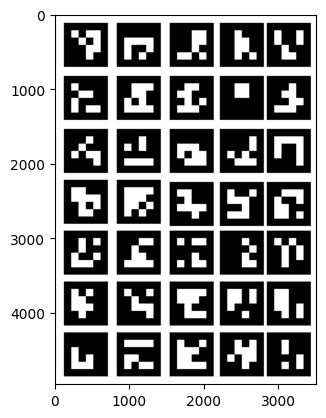

In [5]:
plt.imshow(img_rgb)

In [6]:
adictNames = [adict for adict in dir(cv2.aruco) if re.match(r'^DICT_', adict)]
arucoMembers = dict(getmembers(cv2.aruco))

In [56]:
arucoMembers

{'ARUCO_CCW_CENTER': 0,
 'ARUCO_CW_TOP_LEFT_CORNER': 1,
 'ArucoDetector': cv2.aruco.ArucoDetector,
 'Board': cv2.aruco.Board,
 'CORNER_REFINE_APRILTAG': 3,
 'CORNER_REFINE_CONTOUR': 2,
 'CORNER_REFINE_NONE': 0,
 'CORNER_REFINE_SUBPIX': 1,
 'CharucoBoard': cv2.aruco.CharucoBoard,
 'CharucoDetector': cv2.aruco.CharucoDetector,
 'CharucoParameters': cv2.aruco.CharucoParameters,
 'DICT_4X4_100': 1,
 'DICT_4X4_1000': 3,
 'DICT_4X4_250': 2,
 'DICT_4X4_50': 0,
 'DICT_5X5_100': 5,
 'DICT_5X5_1000': 7,
 'DICT_5X5_250': 6,
 'DICT_5X5_50': 4,
 'DICT_6X6_100': 9,
 'DICT_6X6_1000': 11,
 'DICT_6X6_250': 10,
 'DICT_6X6_50': 8,
 'DICT_7X7_100': 13,
 'DICT_7X7_1000': 15,
 'DICT_7X7_250': 14,
 'DICT_7X7_50': 12,
 'DICT_APRILTAG_16H5': 17,
 'DICT_APRILTAG_16h5': 17,
 'DICT_APRILTAG_25H9': 18,
 'DICT_APRILTAG_25h9': 18,
 'DICT_APRILTAG_36H10': 19,
 'DICT_APRILTAG_36H11': 20,
 'DICT_APRILTAG_36h10': 19,
 'DICT_APRILTAG_36h11': 20,
 'DICT_ARUCO_MIP_36H12': 21,
 'DICT_ARUCO_MIP_36h12': 21,
 'DICT_ARUCO_ORIGI

In [7]:
def unpack_corners(corners):
    (tl, tr, br, bl) = corners
    # convert each of the (x, y)-coordinate pairs to integers
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    tl = (int(tl[0]), int(tl[1]))
    return (tr, br, bl, tl)



In [28]:
def draw_corners(image, corners, markerID):
    (tl, tr, br, bl) = unpack_corners(corners)
    # convert each of the (x, y)-coordinate pairs to integers
    cv2.line(image, tl, tr, (0, 255, 0), 12)
    cv2.line(image, tr, br, (0, 255, 0), 12)
    cv2.line(image, br, bl, (0, 255, 0), 12)
    cv2.line(image, bl, tl, (0, 255, 0), 12)

    cX = int((tl[0] + br[0]) / 2.0)
    cY = int((tl[1] + br[1]) / 2.0)
    cv2.circle(image, (cX, cY), 20, (255, 0, 0), -1)
    cv2.putText(image, str(markerID),
        (tl[0], tl[1] - 15), cv2.FONT_HERSHEY_SIMPLEX,
        2, (0, 255, 0), 4)

    return image

[INFO] detected 35 markers for 'DICT_4X4_100'
[INFO] detected 35 markers for 'DICT_4X4_1000'
[INFO] detected 35 markers for 'DICT_4X4_250'
[INFO] detected 35 markers for 'DICT_4X4_50'
[INFO] detected 4 markers for 'DICT_ARUCO_MIP_36H12'
[INFO] detected 4 markers for 'DICT_ARUCO_MIP_36h12'


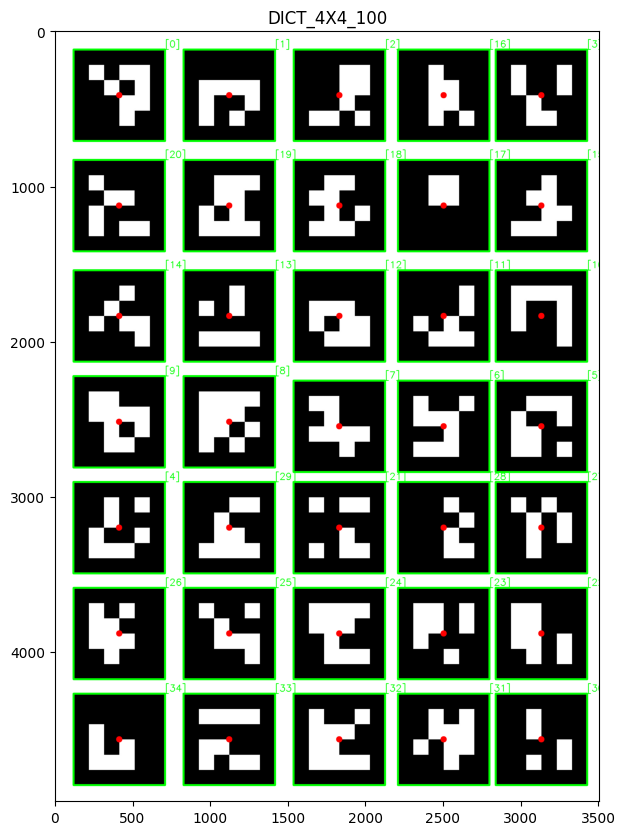

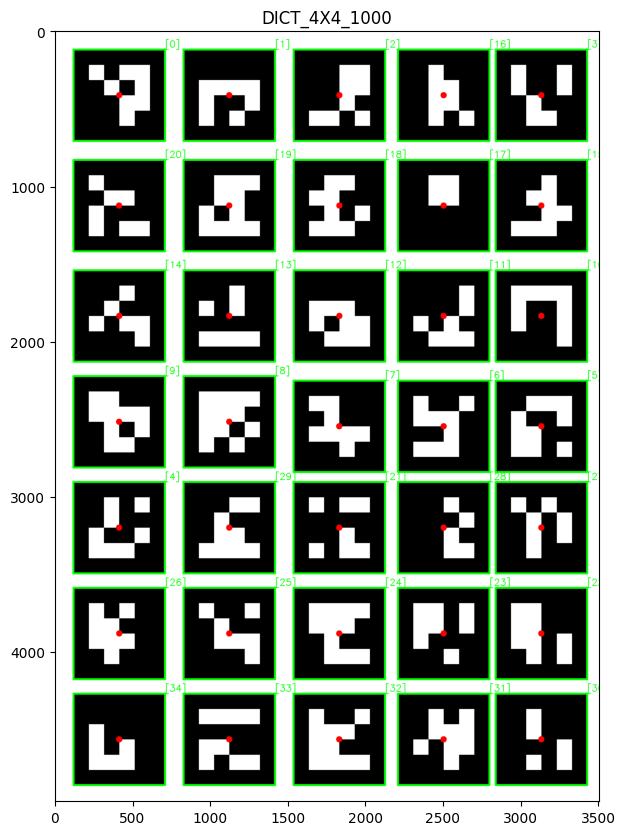

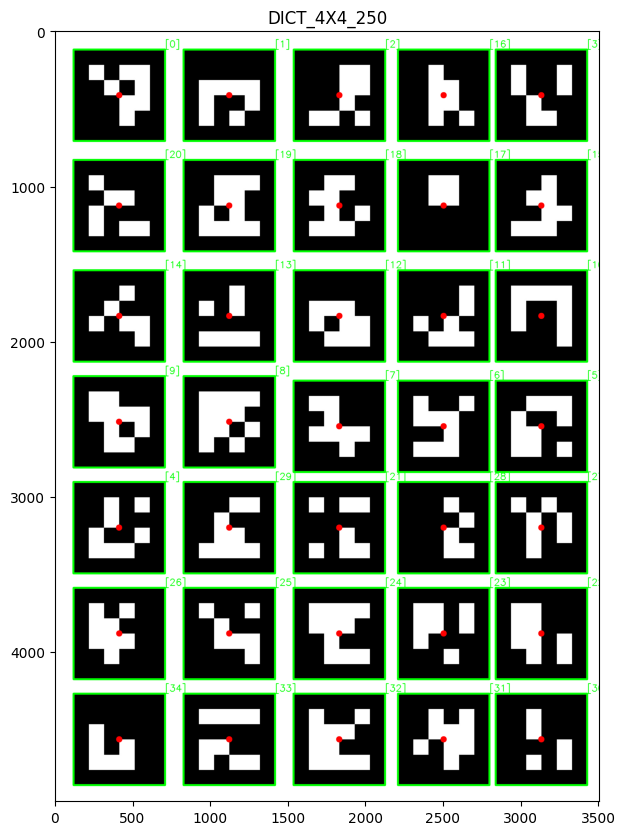

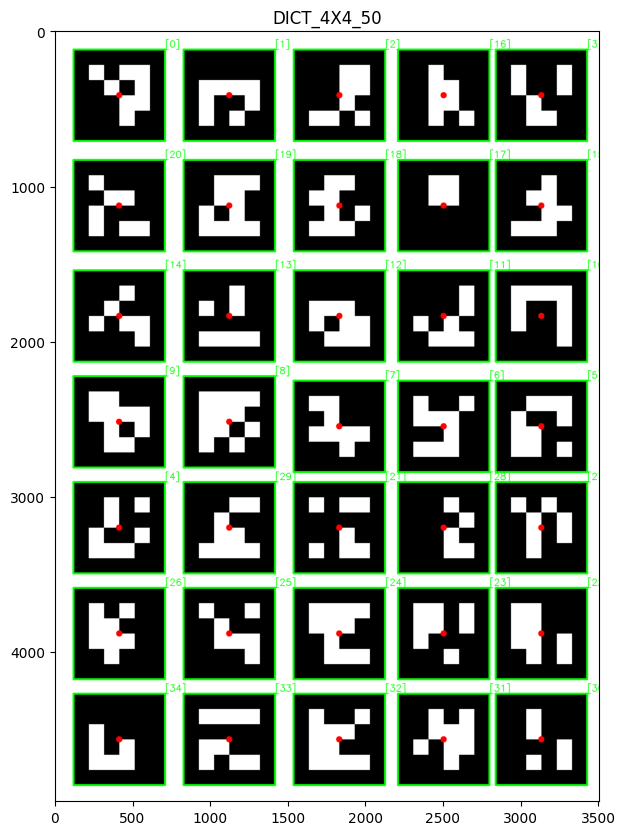

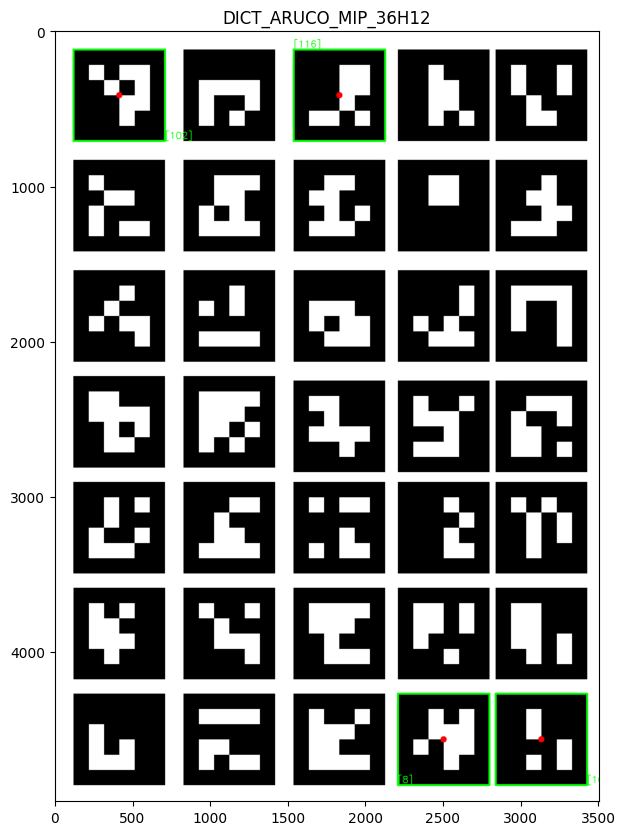

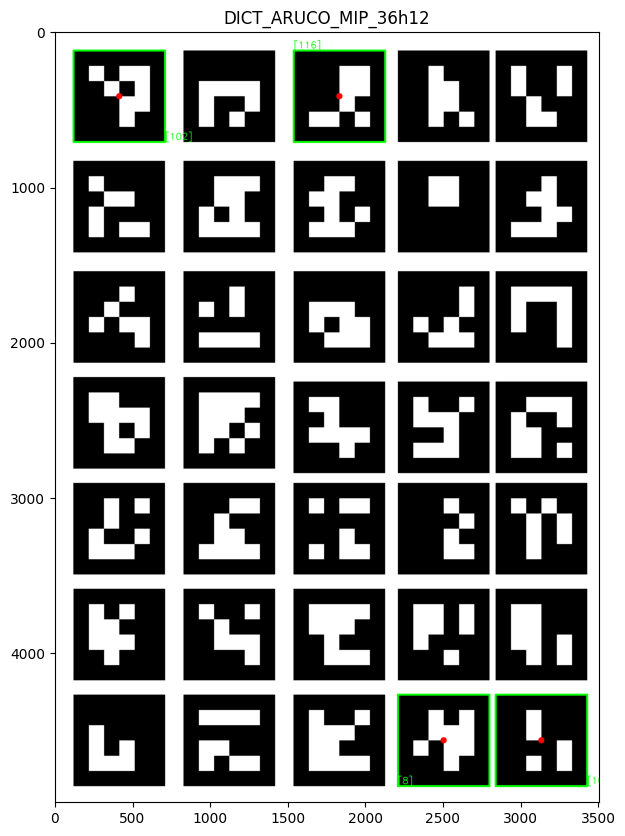

In [30]:
for adictName in adictNames:
    aruco_image = img.copy()
    adict = arucoMembers[adictName]
    arucoDict = cv2.aruco.getPredefinedDictionary(adict)
    arucoParams = cv2.aruco.DetectorParameters()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(
		img, arucoDict, parameters=arucoParams)

    if len(corners) > 0:
        #print(f"ids: {*ids,}")
        print("[INFO] detected {} markers for '{}'".format(
            len(corners), adictName))
        
        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            corners = markerCorner.reshape((4, 2))
            aruco_image = draw_corners(aruco_image, corners, markerID)
        plt.figure(figsize=(10,10))
        plt.title(adictName)
        plt.imshow(aruco_image)

## Pose Estimation

In [39]:
def estimatePose(corners, marker_size, K, dist, method=cv2.SOLVEPNP_IPPE_SQUARE) -> (list, list, list):
    """ Estimate Pose through pnp using marker size and camera intrinsics """
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                           [marker_size / 2, marker_size / 2, 0],
                           [marker_size / 2, -marker_size / 2, 0],
                           [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    
    for c in corners:
        retval, rvec, tvec = cv2.solvePnP(marker_points, corners[i], K, dist, False, method)
        rvecs.append(rvec)
        tvecs.append(tvec)
        retvals.append(retval)

    return rvecs, tvecs, retvals

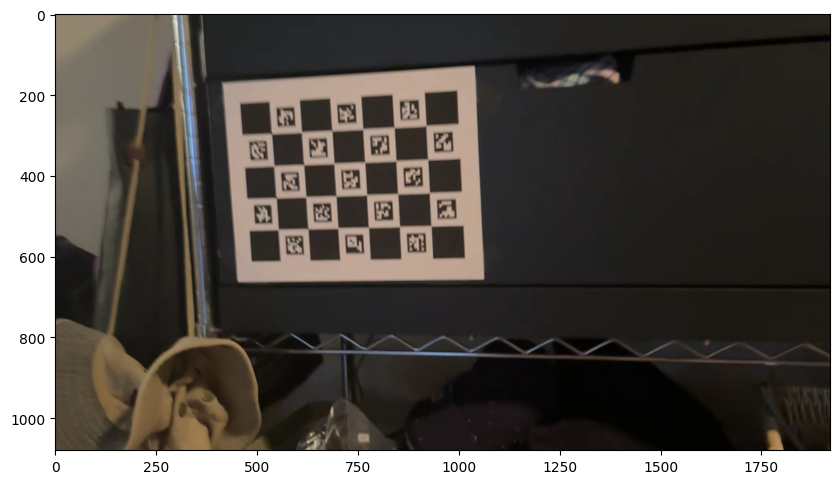

In [53]:
arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
arucoParams = cv2.aruco.DetectorParameters()

K = np.load("calibration_matrix.npy")
img_path = os.getcwd() + "/aruco_images/30.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)

In [57]:
arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_1000)
arucoParams = cv2.aruco.DetectorParameters()
(corners, ids, rejected) = cv2.aruco.detectMarkers(
    img, arucoDict, parameters=arucoParams)

In [ ]:
def aruco_display(corners, ids, rejected, image):
    if len(corners) <= 0:
        print("No corners to display")
        return image

    ids = ids.flatten()
    for (markerCorner, markerID) in zip(corners, ids):
        # extract the marker corners (which are always returned in
        # top-left, top-right, bottom-right, and bottom-left order)
        corners = markerCorner.reshape((4, 2))
        (topLeft, topRight, bottomRight, bottomLeft) = corners
        # convert each of the (x, y)-coordinate pairs to integers
        topRight = (int(topRight[0]), int(topRight[1]))
        bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
        bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
        topLeft = (int(topLeft[0]), int(topLeft[1]))

        cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
        cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
        cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
        cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
        # compute and draw the center (x, y)-coordinates of the ArUco
        # marker
        cX = int((topLeft[0] + bottomRight[0]) / 2.0)
        cY = int((topLeft[1] + bottomRight[1]) / 2.0)
        cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
        # draw the ArUco marker ID on the image
        cv2.putText(image, str(markerID),(topLeft[0], topLeft[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (0, 255, 0), 2)
        print("[Inference] ArUco marker ID: {}".format(markerID))
        # show the output image    
    
        

In [58]:
detected_markers = aruco_display(corners, ids, rejected, image)
plt.imshow(detected_markers

(array([[[908., 378.],
         [911., 426.],
         [866., 428.],
         [864., 380.]]], dtype=float32),
 array([[[983., 291.],
         [987., 339.],
         [941., 343.],
         [938., 294.]]], dtype=float32))